# Équation de Burgers et flux de Rusanov

Dans ce TP, on considère le problème
$$
    \partial_t u(x,t) + \partial_x [f(u)] = 0,
$$
sur le domaine périodique $x \in \mathbb{R} / 2\mathbb{Z}$ et un temps final arbitraire $t \in ]0, +\infty[$, avec le flux $f(u) = \frac{1}{2}u^2$.

### 1/ Implémentation de la méthode numérique

**1.1.** On utilise une discrétisation $x_j = (j - 1/2) \Delta x$ avec $\Delta x = L/N_x$ et $j \in \{1, ..., N_x\}$. Écrire une fonction `discretisation` qui prend en entrée le nombre de points `Nx` et qui renvoie un vecteur `x` de points de collocation et le pas de maillage `dx`.

In [9]:
# x ds [0, L] avec CB periodique x ds R / LZ
L = 2.0
function discretisation(Nx)
    dx = L / Nx
    x = [(i-0.5)dx for i in 1:Nx]
    return x, dx
end

discretisation (generic function with 1 method)

In [10]:
"test"
x, dx = discretisation(2)
println(x, dx)

[0.5, 1.5]1.0


**1.2.** Créer des fonctions `f` et `df` qui représentent respectivement le flux dans l'équation de Burgers et sa dérivée.

In [11]:
f(u) = 0.5 * u^2
df(u) = Float64(u)

df (generic function with 1 method)

**1.3.a)** Écrire une fonction `rusanov_flux` qui prend en entrée une donnée à gauche `uL` et une donnée à droite `uR`, qui calcule le flux numérique $(u_L, u_R) \mapsto g(u_L, u_R)$ par méthode de Rusanov.

**1.3.b)** Un calcul à la main donne $g(2,4) = 1$. Le code ci-dessous vérifie que `rusanov_flux(1,2)` donne le même résultat. De même, calculer à la main les valeurs de $g(4,2)$ et $g(-4,2)$ et les comparer avec les sorties de la fonction implémentée.

In [12]:
function rusanov_flux(uL, uR)
    lambda = max(abs(df(uL)), abs(df(uR)))
    return 0.5*(f(uL) + f(uR)) - 0.5*lambda*(uR - uL)
end

println("g(2,4) = 1, ", rusanov_flux(2.0, 4.0) ≈ 1.0) # on utilise `\approx` pour écrire `≈`, ou on utilise `isapprox`
println("g(4,2) = 9, ", rusanov_flux(4.0, 2.0) ≈ 9)
println("g(-4,2) = -7, ", rusanov_flux(-4.0, 2.0) ≈ -7)

g(2,4) = 1, true
g(4,2) = 9, true
g(-4,2) = -7, true


**1.4.a)** Compléter la fonctions `compute_flux!` ci-dessous. On la teste ensuite avec la donnée $u_1 = 2,\ u_2 = 4$, à comparer avec un calcul à la main de $f_{1/2}$ et $f_{3/2} = f_{-1/2}$.

In [13]:
"Remplit le vecteur `flux` de sorte que `flux[j]` soit le flux numérique à l'interface entre `u[j-1]` et `u[j]`.
 Ne fait pas d'allocations."
function compute_flux!(flux, u)
    n = length(flux)
    flux[1] = rusanov_flux(u[n], u[1]) # u[1] = u[0] = u[n] car periodique
    for j in 2:n
        flux[j] = rusanov_flux(u[j-1], u[j])
    end
end

test_flux_u = [2.0, 4.0]
test_flux_flux = [NaN, NaN]
compute_flux!(test_flux_flux, test_flux_u)
print(test_flux_flux)

[9.0, 1.0]

**1.4.b)** Compléter la fonction `step_muscl!` ci-dessous. On la teste ensuite avec la donnée $u_1 = 1,\ u_2 = 2$ et le flux numérique $f_{1/2}= 5,\ f_{3/2} = f_{-1/2} = 20$.

In [14]:
"Modifie `u` pour passer d'un temps t à un temps t + dt, en supposant que `flux` a été calculé et
que β est le nombre CFL, β = dt/dx. Ne fait pas d'allocations."
function step_muscl!(u, flux, β)
    n = length(flux)
    u[n] = u[n] - β * (flux[1] - flux[n])
    for j in 1:n-1
        u[j] = u[j] - β * (flux[j+1] - flux[j])
    end
end

test_step_u = [1.0, 2.0]
test_flux_flux = [5.0, 20.0] # flux artificiel pour tester la fonction
step_muscl!(test_step_u, test_flux_flux, 1.0)
display(test_step_u)

2-element Vector{Float64}:
 -14.0
  17.0

**1.4.c)** Fonction qui prend en entrée une fonction une fonction `u0`, un nombre de points de collocation `Nx`, un temps final `T` et un nombre de pas de temps `Nt`, et qui renvoie le maillage et la solution numérique au temps final.

In [15]:
function simulate_rusanov(u0, Nx, T, Nt)
    x, dx = discretisation(Nx)
    u = u0.(x)
    dt = T / (Nt-1)
    flux = similar(u)
    cfl = dt / dx

    for _ in 1:Nt
        compute_flux!(flux, u)
        step_muscl!(u, flux, cfl )
    end

    return x, u
end

simulate_rusanov (generic function with 1 method)

### 2/ Application de la méthode à un problème de Riemann

On applique maintenant cette méthode au problème avec une condition initiale 

$$ \tag{$\star$}
    u(x, 0) = u_0(x) = 1 + 2\chi_{]0,1[}(x) = \begin{cases} 3 & \text{ si } x \in ]0, 1[ , \\ 1 & \text{ sinon} . \end{cases}
$$

Pour débugger les implémentations précédentes, on peut commencer par la Partie 2.2.


#### 2.1. Calcul exact de solution

On commence par quelques propriétés sur le problème de Riemann sur le domaine $x \in \mathbb{R}$, $u_0(x) = \begin{cases} u_L & \text{ si } x < 0 \\ u_R & \text{ si } x \geq 0 \end{cases}$. En cas de choc, la vitesse $\sigma$ du choc est déterminée par la condition de Rankine-Hugoniot,
$$
\sigma = \bigl( f(u_R) - f(u_L) \bigr) / (u_R - u_L) .
$$
En cas de relaxation, la solution sur la partie indéterminée par les caractéristiques est donnée par une interpolation affine entre les parties déterminées.

**2.1.a)** Qu'est-ce qui détermine si une discontinuité engendre un choc ou une relaxation ?

**2.1.b)** On considère la discontinuité située en $x = 0$ pour la condition initiale $(\star)$. S'agit-il d'un choc ou d'une relaxation ? S'il s'agit d'un choc, déterminer sa vitesse.

**2.1.c)** Idem pour la discontinuité en $x = 1$.

**2.1.d)** En traçant au brouillon les caractéristiques de $u_0(0^-)$, $u_0(0^+)$, $u_0(1^-)$ et $u_0(1^+)$, déterminer la solution exacte au temps $t = 1/2$.

#### 2.2. Quelques simulations

**2.2.a)** Calculer la solution à un temps $T = 1/2$ avec $N_x \in \{70, 200, 8000\}$ et $N_t = 10^4$.

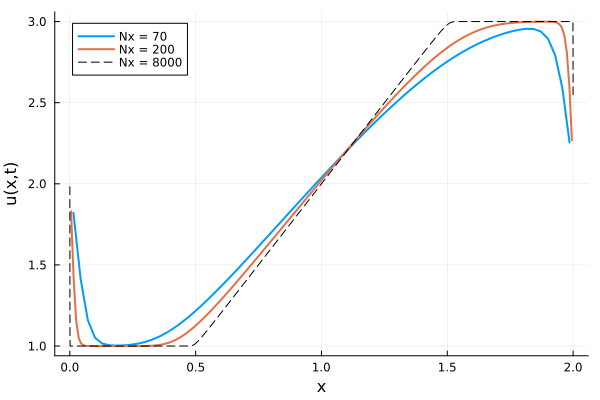

In [16]:
using Plots


u0(x) = (0 < x < 1) ? 3.0 : 1.0

T = 0.5
Nt = 10^4

plot(xlabel="x", ylabel="u(x,t)")

Nx = 70
x, u1 = simulate_rusanov(u0, Nx, T, Nt)
plot!(x, u1, label="Nx = 70", linewidth=2)

Nx = 200
x, u2 = simulate_rusanov(u0, Nx, T, Nt)
plot!(x, u2, label="Nx = 200", linewidth=2)

Nx = 8000
x, u3 = simulate_rusanov(u0, Nx, T, Nt)
plot!(x, u3, label="Nx = 8000", linestyle=:dash, color=:black)


**2.2.b)** Tracer ces solutions et commenter.

J'ai aucune idée de ce que ces solutions veulent dire...